# Song Recommendation System

## Initialization

In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
from mlxtend.frequent_patterns import fpgrowth
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
file_path_songs = "Data/Music Info.csv"
df_songs = pd.read_csv(file_path_songs)
file_path_users = "Data/User Listening History.csv"
df_users = pd.read_csv(file_path_users)

print(df_users.head())

             track_id                                   user_id  playcount
0  TRIRLYL128F42539D1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
1  TRFUPBA128F934F7E1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
2  TRLQPQJ128F42AA94F  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
3  TRTUCUY128F92E1D24  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1
4  TRHDDQG12903CB53EE  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1


## Data Inspection

/Users/paulagranlund/.julia/conda/3/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/paulagranlund/.julia/conda/3/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/paulagranlund/.julia/conda/3/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


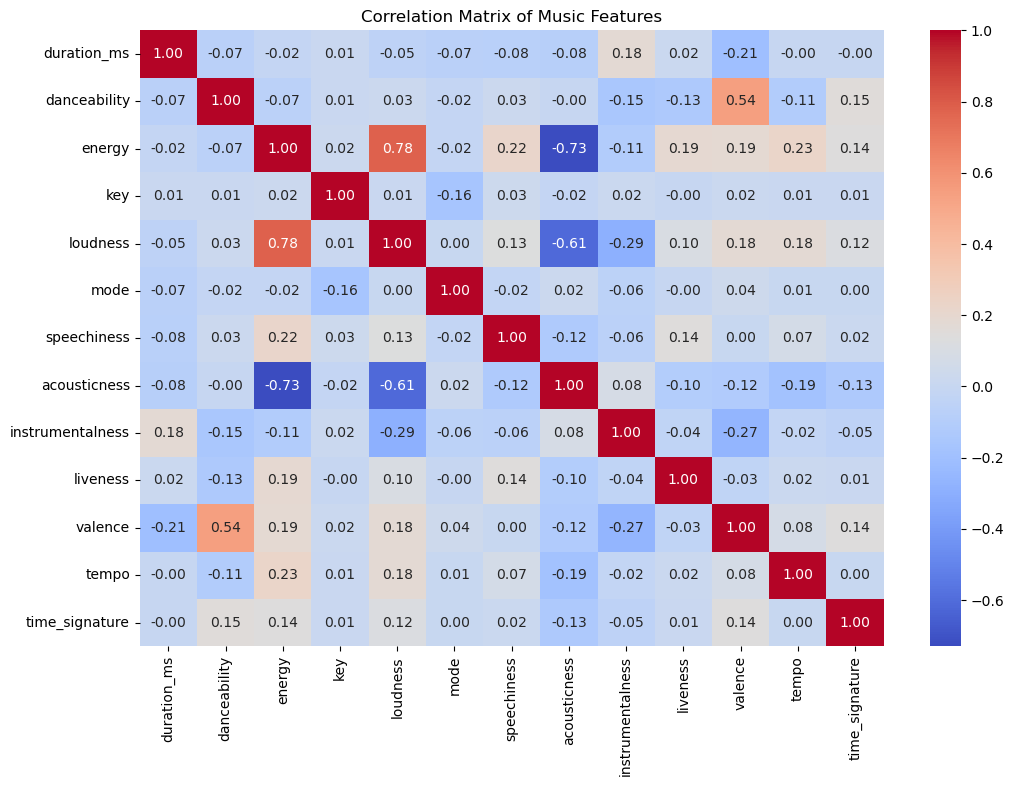

In [5]:
selected_columns = ['duration_ms', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 
                    'tempo', 'time_signature']

# Extract the relevant data from the DataFrame
music_data = df_songs[selected_columns]

# Calculate the correlation matrix
correlation_matrix = music_data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Music Features')
plt.show()

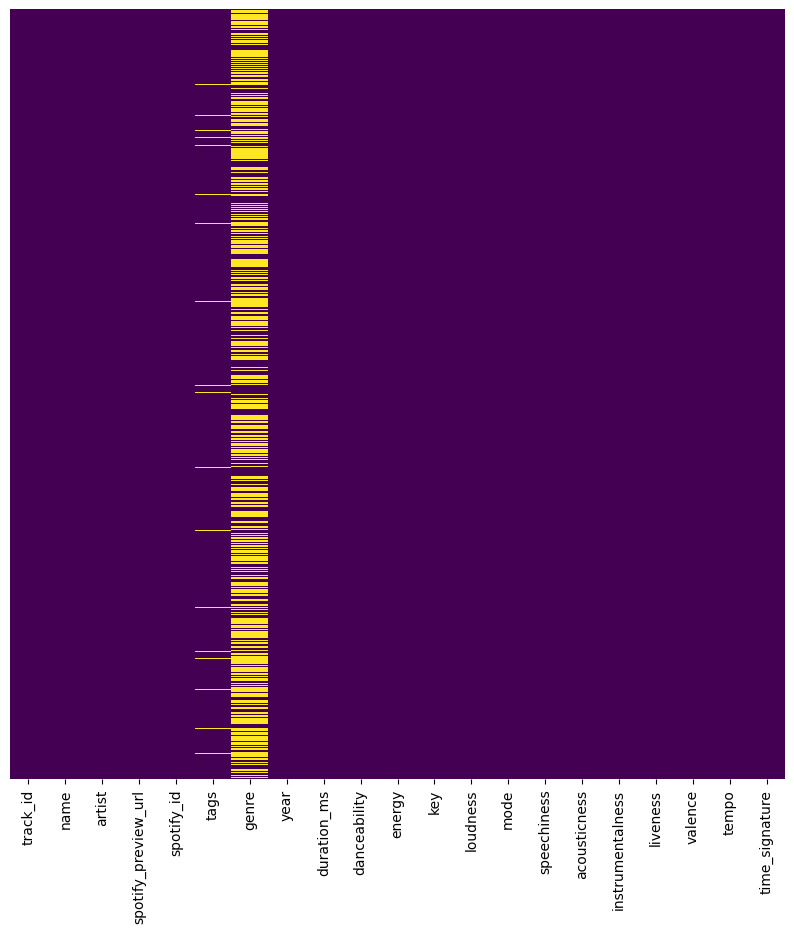

In [6]:
plt.figure(figsize = (10,10))
sns.heatmap(df_songs.sample(n = 10000, random_state = 1).isnull(), cmap  = 'viridis', cbar = False, yticklabels = False,
            # xticklabels= False
            )
plt.show()

I believe this explains why we could use the neural network to predict genre for those observations where the attribute is missing.

## Clustering: Cluster the user base

Maybe we need to cluster the users otherwise we have too many items (songs) when using one hot encoding on the baskets later. We could try cluster on different parameters and see what minimizes the number of items in each basket.

## Frequent Itemsets: Market basket

In [10]:
# Calculate the total play count for each user
user_total_playcount = df_users.groupby('user_id')['playcount'].sum().reset_index()
user_total_playcount = user_total_playcount[user_total_playcount['playcount'] >= 200]

# Filter the original user data to include only users with at least 100 total plays
df_users_filtered = df_users[df_users['user_id'].isin(user_total_playcount['user_id'])]

# Sort songs for each user by play count and select the top 10 most played songs
def get_top_songs(user_data):
    return user_data.nlargest(10, 'playcount')

# Apply the top song selection for each user
df_top_songs = df_users_filtered.groupby('user_id').apply(get_top_songs).reset_index(drop=True)

# Create a basket for each user with their top 10 songs (or fewer)
df_basket = df_top_songs.groupby('user_id')['track_id'].apply(list).reset_index()
df_basket.rename(columns={'track_id': 'basket'}, inplace=True)

# Display the resulting DataFrame
print(df_basket)

                                        user_id  \
0      0007be5e1168b8e4c7de1f9639eeaa1bbff44b94   
1      000e9296161b73a1821aaed3d7f50d95e8665bf6   
2      0015de25f44c66b36551716f1658e295ea09cfe0   
3      00174ccfb573aa9e1aa097772e801539a2f4c75d   
4      001889ee41b5f31c404a1abe4af07b2377fa776b   
...                                         ...   
10742  ffef301626a2e5af57cc470a26d9b8df8e87e5ca   
10743  fff0a18cfc99ccf99c483d362a8f47c11e1a6410   
10744  fff759a45a3a68de552740e8285a97d5f65d4e58   
10745  fff9bd021bf6e07936883b9bb045207fcf372a2c   
10746  fffb0b218640d86e5cb99d41cd3ecad977142da5   

                                                  basket  
0      [TROMKCG128F9320C09, TRXHLUP128F9320B70, TRQFI...  
1      [TRIPLBA128F427200F, TRARTEH128F423DBC1, TRPHD...  
2      [TRRABPE128F42AA877, TRRZEOQ128F930C163, TRDDR...  
3      [TRWVOJJ12903CCC654, TRIXLAY128F930C1C0, TRSLM...  
4      [TRZNAHL128F9327D5A, TRPLXFD128F1454961, TRVHP...  
...                              

/var/folders/1m/z6bjwn212yg9839rhl52qvtm0000gn/T/ipykernel_46149/1092689158.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_top_songs = df_users_filtered.groupby('user_id').apply(get_top_songs).reset_index(drop=True)


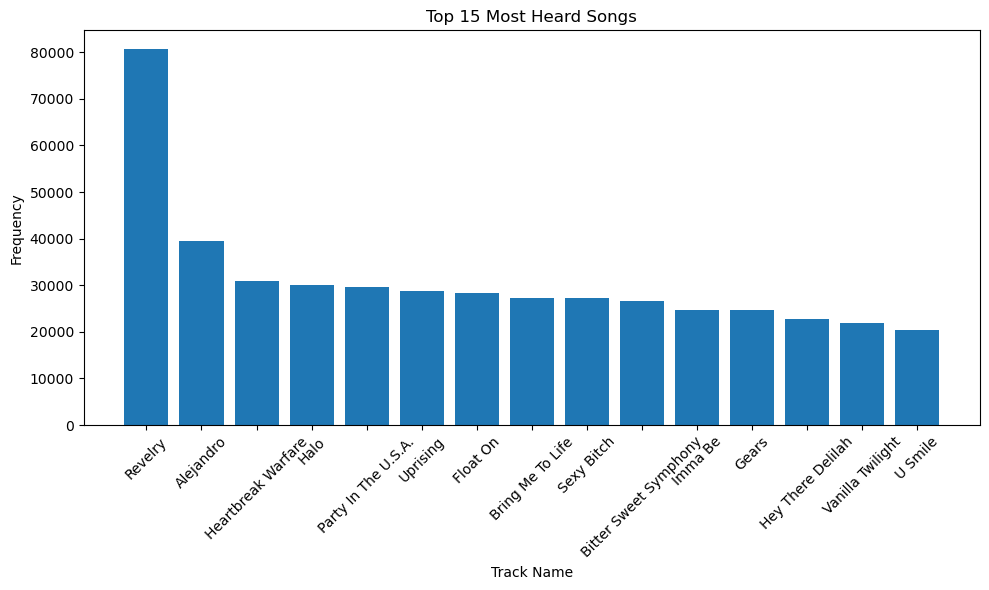

In [8]:
track_freq = df_users['track_id'].value_counts().reset_index()
track_freq.columns = ['track_id', 'frequency']

track_freq = track_freq.merge(df_songs, on='track_id')

top_15_tracks = track_freq.head(15)

plt.figure(figsize=(10, 6))
plt.bar(top_15_tracks['name'], top_15_tracks['frequency'])
plt.xlabel('Track Name')
plt.ylabel('Frequency')
plt.title('Top 15 Most Heard Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()